In [1]:
# Imports
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from git import Repo  
import json, jsonlines, os, glob, pandas as pd, numpy as np
import glob, gzip, jsonlines

# Load training data
train_ds = load_dataset("ahmadreza13/human-vs-Ai-generated-dataset", split="train")
train_small = train_ds.shuffle(seed=42).select(range(int(len(train_ds))))
X_train, y_train = train_small["data"], train_small["generated"]

# Build pipeline
svm = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="word",
        ngram_range=(1,2),
        max_features=60_000,
        stop_words="english",
        sublinear_tf=True)),
    ("clf",  LinearSVC(class_weight="balanced"))
])

print("Training SVM on", len(X_train), "documents …")
svm.fit(X_train, y_train)

# Clone dev set repo
DEV_REPO = "cs162-final-dev"
if not os.path.exists(DEV_REPO):
    Repo.clone_from("https://github.com/skgabriel/cs162-final-dev.git", DEV_REPO)

def collect_dev_jsonl(pattern="cs162-final-dev/**/*.jsonl"):
    texts, labels = [], []

    for fname in glob.glob(pattern, recursive=True):
        opener = gzip.open if fname.endswith(".gz") else open
        with opener(fname, "rt", encoding="utf-8") as fh:
            reader = jsonlines.Reader(fh)
            for obj in reader:
                if "human_text" in obj:
                    texts.append(obj["human_text"])
                    labels.append(0)
                if "machine_text" in obj:
                    texts.append(obj["machine_text"])
                    labels.append(1)

    return texts, labels

X_test, y_test = collect_dev_jsonl()
print("Loaded", len(X_test), "examples")
assert len(X_test) > 0
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Human (0)", "AI (1)"]))

print("\nConfusion Matrix")
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                   index=["Actual Human","Actual AI"],
                   columns=["Pred Human","Pred AI"]))

/Users/zhenyusong/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training SVM on 3614247 documents …
Loaded 24000 examples
              precision    recall  f1-score   support

   Human (0)       0.69      0.70      0.70     12000
      AI (1)       0.70      0.69      0.70     12000

    accuracy                           0.70     24000
   macro avg       0.70      0.70      0.70     24000
weighted avg       0.70      0.70      0.70     24000


=== confusion matrix ===
              Pred Human  Pred AI
Actual Human        8394     3606
Actual AI           3684     8316


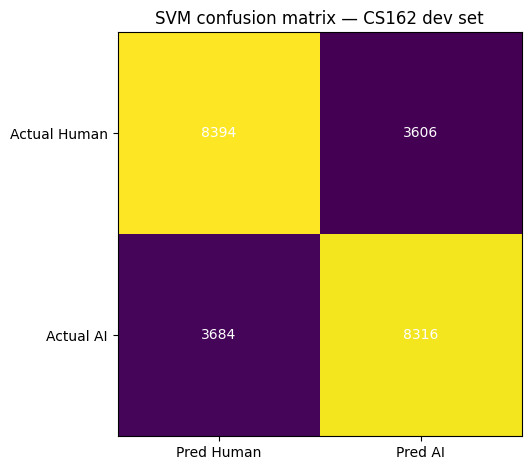

In [2]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred) 
fig, ax = plt.subplots()
im = ax.imshow(cm)

ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Pred Human', 'Pred AI'])
ax.set_yticklabels(['Actual Human', 'Actual AI'])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="white")
        
ax.set_title("SVM confusion matrix — CS162 dev set")
plt.tight_layout(); plt.show()


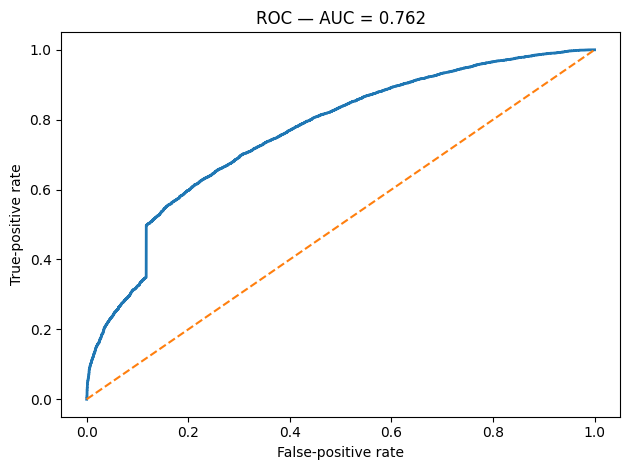

In [3]:
from sklearn.metrics import roc_curve, auc

scores = svm.decision_function(X_test)   
fpr, tpr, _ = roc_curve(y_test, scores)
fig, ax = plt.subplots()

ax.plot(fpr, tpr, lw=2)
ax.plot([0,1], [0,1], linestyle="--")  
ax.set_xlabel("False-positive rate"); ax.set_ylabel("True-positive rate")
ax.set_title(f"ROC — AUC = {auc(fpr, tpr):.3f}")
plt.tight_layout(); plt.show()

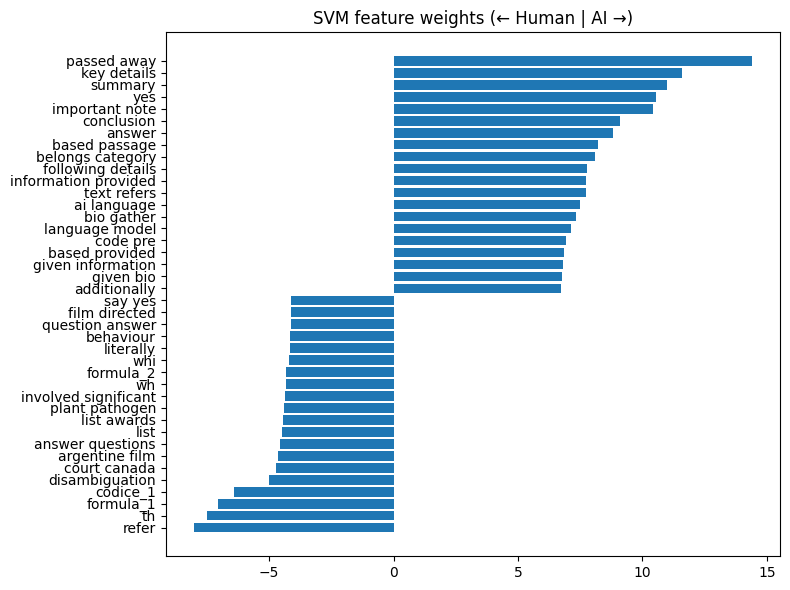

In [4]:
import numpy as np

vec = svm.named_steps["tfidf"]
clf = svm.named_steps["clf"]
feature_names = np.array(vec.get_feature_names_out())
coef = clf.coef_.ravel() 

N = 20
top_pos = np.argsort(coef)[-N:]              # Most positive weights (AI)
top_neg = np.argsort(coef)[:N]               # Most negative weights (human)
top_terms = np.hstack([top_neg, top_pos])
top_weights = coef[top_terms]

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(range(2*N), top_weights)
ax.set_yticks(range(2*N))
ax.set_yticklabels(feature_names[top_terms])
ax.set_title("SVM feature weights (← Human | AI →)")
plt.tight_layout(); plt.show()
